In [4]:
import math
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
import yaml

from sec_certs.cert_rules import PANDAS_KEYWORDS_CATEGORIES, cc_rules
from sec_certs.dataset import CCDataset
from sec_certs.utils.extract import extract_key_paths, rules_get_subset

sns.set_theme(style="white", palette="deep", context="notebook")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

RESULTS_DIR = Path("./results")

In [5]:
dset = CCDataset.from_web_latest()
df = dset.to_pandas()

/var/folders/1h/qt5h035n5rzcjdmfl295hrk80000gn/T/ipykernel_18601/3177735047.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  categories = df.loc[df.year_from < 2024].groupby(["year_from", "category"], as_index=False).size().copy()


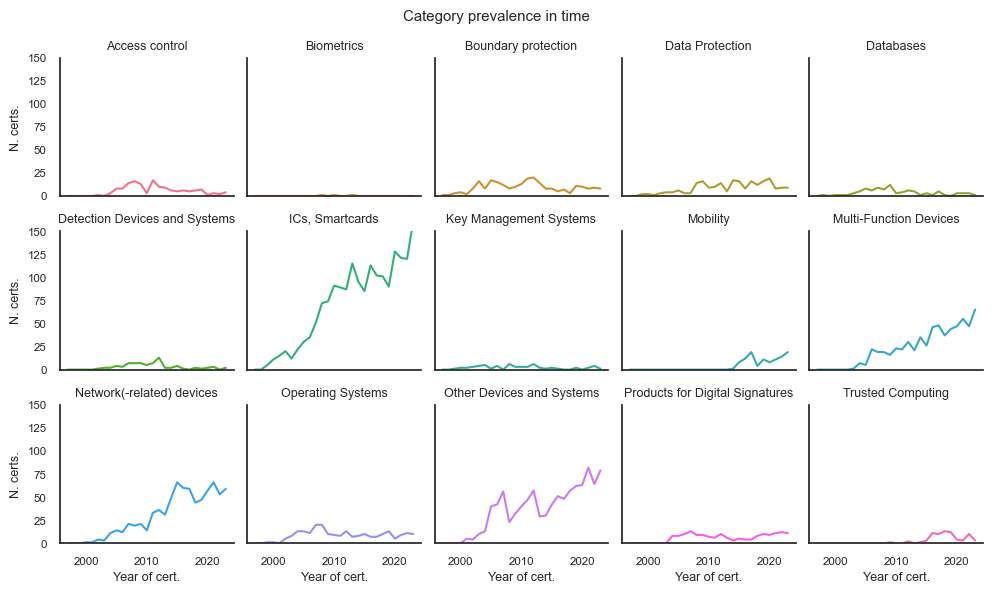

In [7]:
long_categories = {
    "Access Control Devices and Systems": "Access control",
    "Biometric Systems and Devices": "Biometrics",
    "Boundary Protection Devices and Systems": "Boundary protection",
    "ICs, Smart Cards and Smart Card-Related Devices and Systems": "ICs, Smartcards",
    "Network and Network-Related Devices and Systems": "Network(-related) devices",
}

categories = df.loc[df.year_from < 2024].groupby(["year_from", "category"], as_index=False).size().copy()
categories.category = categories.category.map(lambda x: long_categories.get(x, x))

with sns.plotting_context("notebook", font_scale=0.75):
    g = sns.FacetGrid(categories, col="category", hue="category", col_wrap=5, height=2, ylim=(0, 150))
    g.map(sns.lineplot, "year_from", "size")
    g.set(xlabel="Year of cert.", ylabel="N. certs.")
    g.set_titles("{col_name}")
    g.figure.subplots_adjust(top=0.90)
    g.figure.suptitle("Category prevalence in time")
    plt.show()

## Prevalence of most popular categories

In [14]:
popular_categories = {
    "ICs, Smart Cards and Smart Card-Related Devices and Systems",
    "Multi-Function Devices",
    "Network and Network-Related Devices and Systems",
    "Other Devices and Systems",
}
df["popular_categories"] = df.category.map(lambda x: x if x in popular_categories else "One of 11 other categories")
n_certs_popular = df.loc[df.category.isin(popular_categories)].shape[0]
n_certs_all = df.shape[0]
print(f"N certs in popular categories: {n_certs_popular} ({(100 * n_certs_popular / n_certs_all):.2f}%)")

n_certs = (
    df.astype({"year_from": "category"})
    .loc[df.year_from < 2024]
    .groupby(["popular_categories", "year_from"], as_index=False)
    .size()
)
n_certs.to_csv(RESULTS_DIR / "popular_categories.csv")

cats = n_certs.popular_categories.unique()
years = n_certs.year_from.cat.categories[:-1]
data = [n_certs.loc[n_certs.popular_categories == c, "size"].tolist()[:-1] for c in cats]

palette = sns.color_palette("Spectral", 5).as_hex()

# plt.style.use("seaborn-v0_8-white")
# plt.figure(figsize=(7, 4))
# plt.stackplot(years, data, labels=cats, colors=palette)
# plt.legend(loc="upper left")
# plt.ylabel("Number of issued certificates")
# plt.xlabel("Year of certification")
# plt.xlim(1997, 2021)
# plt.show()
# plt.style.use("seaborn-whitegrid")

N certs in popular categories: 4269 (74.87%)


/var/folders/1h/qt5h035n5rzcjdmfl295hrk80000gn/T/ipykernel_18601/1885810443.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["popular_categories", "year_from"], as_index=False)


## Security level distribution over time

In [ ]:
sec_levels = df.loc[df.year_from < 2022].groupby(["year_from", "eal"], as_index=False).size()
line = sns.lineplot(data=sec_levels, x="year_from", y="size", hue="eal")
line.set(
    xlabel="Year of certification", ylabel="Number of issued certificates", title="Security level prevalence in time"
)
line.legend(title="Security level", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

## Average security level over time

- Quantify security level as number from 0 (EAL1) to 13 (EAL7+)
- Show three plots:
    1. lineplot of average security level over time
    2. scatter plot of average security level over time, where size of dot is weighted by the number of certificates issued in the given year
    3. Show fitted line plot of average security level over time
- Year 1999 is a clear outlier, print its certificates 

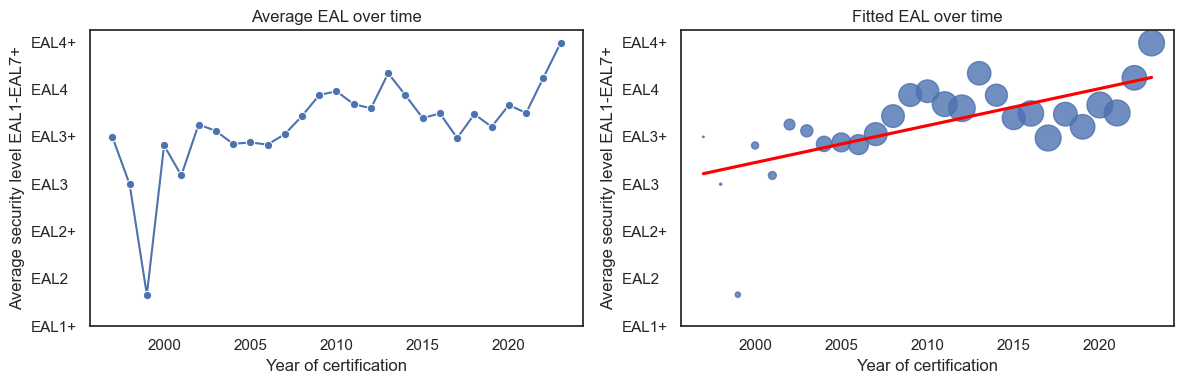

/var/folders/1h/qt5h035n5rzcjdmfl295hrk80000gn/T/ipykernel_18601/580250858.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["year_from", "category"])


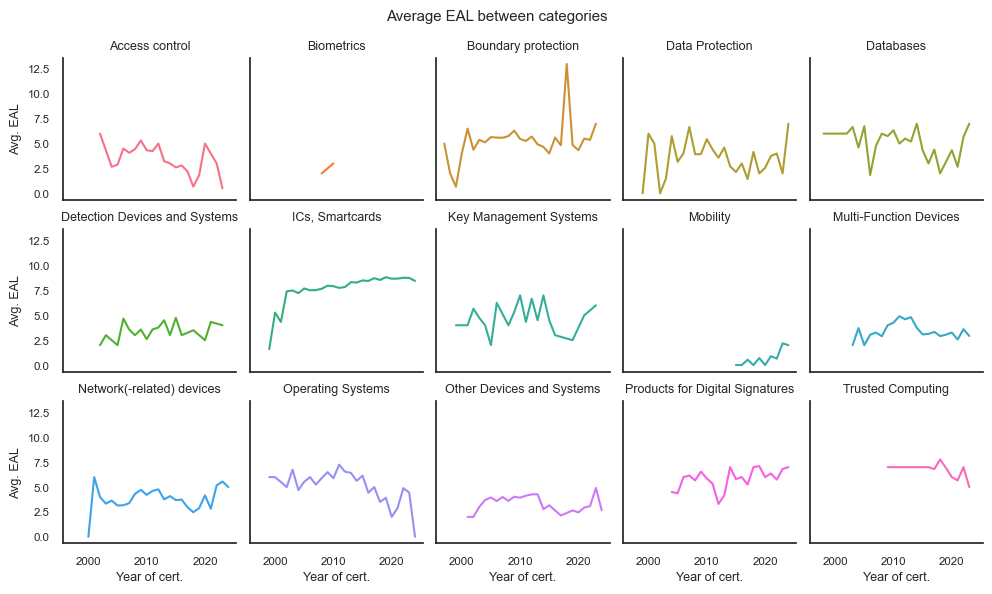

/var/folders/1h/qt5h035n5rzcjdmfl295hrk80000gn/T/ipykernel_18601/580250858.py:67: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  line = sns.lineplot(


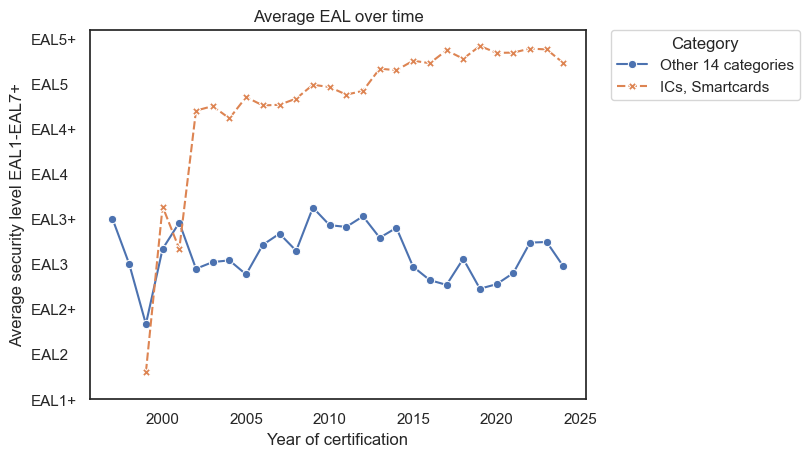

In [9]:
eal_to_num_mapping = {eal: index for index, eal in enumerate(df["eal"].cat.categories)}
df["eal_number"] = df.eal.map(eal_to_num_mapping)
df.eal_number = df.eal_number.astype("Int64")
avg_levels = (
    df.loc[(df.year_from < 2024) & (df.eal_number.notnull())]
    .copy()
    .groupby(["year_from"])
    .agg({"year_from": "size", "eal_number": "mean"})
    .rename(columns={"year_from": "n_certs"})
    .reset_index()
)
avg_levels.year_from = avg_levels.year_from.astype("float")
avg_levels.eal_number = avg_levels.eal_number.astype("float")

ymin = math.floor(avg_levels.eal_number.min())
ymax = math.ceil(avg_levels.eal_number.max())
ylabels = [
    x if "+" in x else x + "  " for x in list(eal_to_num_mapping.keys())[ymin : ymax + 1]
]  # this also aligns the labels by adding phantom spaces

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(12, 4)
figure.set_tight_layout(True)

line = sns.lineplot(data=avg_levels, x="year_from", y="eal_number", marker="o", ax=axes[0])
line.set(xlabel="Year of certification", ylabel="Average security level EAL1-EAL7+", title="Average EAL over time")
line.set_yticks(range(ymin, ymax + 1), ylabels)

fitted = sns.regplot(
    data=avg_levels,
    x="year_from",
    y="eal_number",
    scatter_kws={"sizes": [1.2 * x for x in list(avg_levels.n_certs)]},
    line_kws={"color": "red"},
    ci=None,
    ax=axes[1],
)
fitted.set(xlabel="Year of certification", ylabel="Average security level EAL1-EAL7+", title="Fitted EAL over time")
fitted.set_yticks(range(ymin, ymax + 1), ylabels)

plt.show()

avg_levels = (
    df.loc[df.eal_number.notnull()]
    .copy()
    .groupby(["year_from", "category"])
    .agg({"year_from": "size", "eal_number": "mean"})
    .rename(columns={"year_from": "n_certs"})
    .reset_index()
)
avg_levels.year_from = avg_levels.year_from.astype("float")
avg_levels.eal_number = avg_levels.eal_number.astype("float")
avg_levels.category = avg_levels.category.map(lambda x: long_categories.get(x, x))

with sns.plotting_context("notebook", font_scale=0.75):
    g = sns.FacetGrid(avg_levels, col="category", hue="category", col_wrap=5, height=2)
    g.map(sns.lineplot, "year_from", "eal_number")
    g.set(xlabel="Year of cert.", ylabel="Avg. EAL")
    g.set_titles("{col_name}")
    g.fig.subplots_adjust(top=0.90)
    g.fig.suptitle("Average EAL between categories")
    plt.show()

avg_levels["smartcard_category"] = avg_levels.category.map(
    lambda x: x if x == "ICs, Smartcards" else "Other 14 categories"
)
line = sns.lineplot(
    data=avg_levels,
    x="year_from",
    y="eal_number",
    hue="smartcard_category",
    ci=None,
    style="smartcard_category",
    markers=True,
)
line.legend(title="Category", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
line.set(xlabel="Year of certification", ylabel="Average security level EAL1-EAL7+", title="Average EAL over time")
ymin = 1
ymax = 9
ylabels = [
    x if "+" in x else x + "  " for x in list(eal_to_num_mapping.keys())[ymin : ymax + 1]
]  # this also aligns the labels by adding phantom spaces
line.set_yticks(range(ymin, ymax + 1), ylabels)

avg_levels.to_csv(RESULTS_DIR / "avg_eal.csv")

## Average SAR levels

Somewhat fragile code, sensible results only for the most popular SARs. Computes their average values over time

In [ ]:
from sec_certs.utils.pandas import discover_sar_families, get_sar_level_from_set

df_sar = df.loc[:, ["eal", "extracted_sars"]]
families = discover_sar_families(df_sar.extracted_sars)
df_sar.eal = df_sar.eal.cat.codes

supports = [df_sar.loc[~df_sar["eal"].isnull()].shape[0]]

for family in tqdm.tqdm(families):
    df_sar[family] = df_sar.extracted_sars.map(lambda x: get_sar_level_from_set(x, family))

most_popular_sars = list(df_sar.isna().sum().sort_values().head(12).index)[2:]
df_sar = df_sar.loc[:, most_popular_sars].join(df.year_from.to_frame())
melted_sars = (
    df_sar.groupby("year_from").mean().reset_index().melt(id_vars="year_from", var_name="SAR", value_name="avg_val")
)

g = sns.FacetGrid(melted_sars, col="SAR", hue="SAR", col_wrap=5, height=2)
g.map(sns.lineplot, "year_from", "avg_val")
g.set(xlabel="Year of cert.", ylabel="Avg. value")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.87)
g.fig.suptitle("Category prevalence in time")
plt.show()

## Average certificate lifetime

Examine average certificate lifetime. Note that approx. 1k certificates expired on a single day, at 2019-09-01.
It may be benefitial to display these plots without these certificates

In [ ]:
df["validity_period"] = (df.not_valid_after - df.not_valid_before).dt.days / 365

# Interesting filtering options: (df.not_valid_after != "2019-09-01"),  (df.cert_link.notnull())
df_validity = df.loc[(df.validity_period.notnull()) & (df.year_from < 2022)]
validity_period = (
    df_validity.groupby("year_from")
    .agg({"year_from": "size", "validity_period": "mean"})
    .rename(columns={"year_from": "n_certs"})
    .reset_index()
)

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(12, 4)
figure.set_tight_layout(True)

line = sns.lineplot(data=validity_period, x="year_from", y="validity_period", marker="o", ax=axes[0])
line.set(
    xlabel="Year of certification",
    ylabel="Average lifetime of certificates (in years)",
    title="Average lifetime of certificates in years",
)

box = sns.boxplot(data=df_validity, x="year_from", y="validity_period", ax=axes[1])
box.set(
    xlabel="Year of certification",
    ylabel="Lifetime of certificates (in years)",
    title="Boxplot of certificate validity periods in individual years",
)
box.tick_params(axis="x", rotation=60)
df_validity[["year_from", "validity_period"]].to_csv(RESULTS_DIR / "df_validity.csv")

strips = sns.relplot(
    kind="scatter", data=df_validity, x="not_valid_before", y="validity_period", height=10, aspect=2 / 1, hue="category"
)
strips.set(
    title="Scatter plot of validity period development over time",
    xlabel="Date of certification",
    ylabel="Validity period of certificate (in years)",
)

scatter = sns.relplot(
    kind="scatter", data=df_validity, x="not_valid_before", y="not_valid_after", height=10, aspect=2 / 1, hue="category"
)
scatter.set(
    title="Scatter plot of validity dates",
    xlabel="Date of certification (not valid before)",
    ylabel="Date of expiry (not valid after)",
)

## Certification scheme & certification laboratory popularity over time

/var/folders/1h/qt5h035n5rzcjdmfl295hrk80000gn/T/ipykernel_18601/2793798180.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  schemes = df.loc[(df.scheme.notnull()) & (df.year_from < 2024)].groupby(["year_from", "scheme"], as_index=False).size()


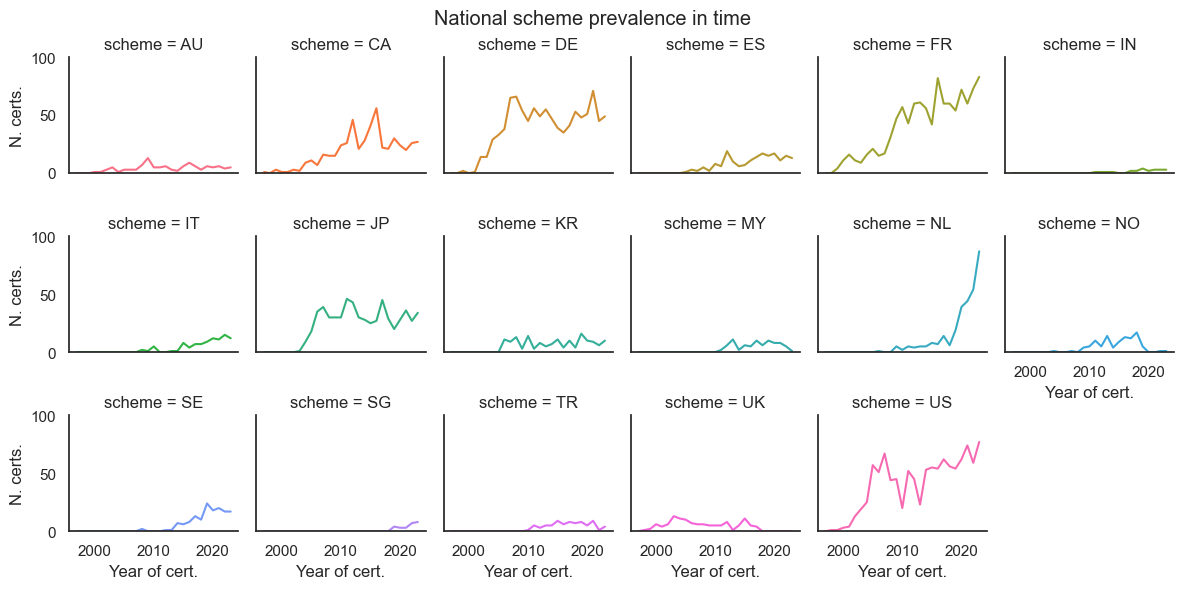

/var/folders/1h/qt5h035n5rzcjdmfl295hrk80000gn/T/ipykernel_18601/2793798180.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labs = df.loc[(df.cert_lab.notnull()) & (df.year_from < 2024)].groupby(["year_from", "cert_lab"], as_index=False).size()


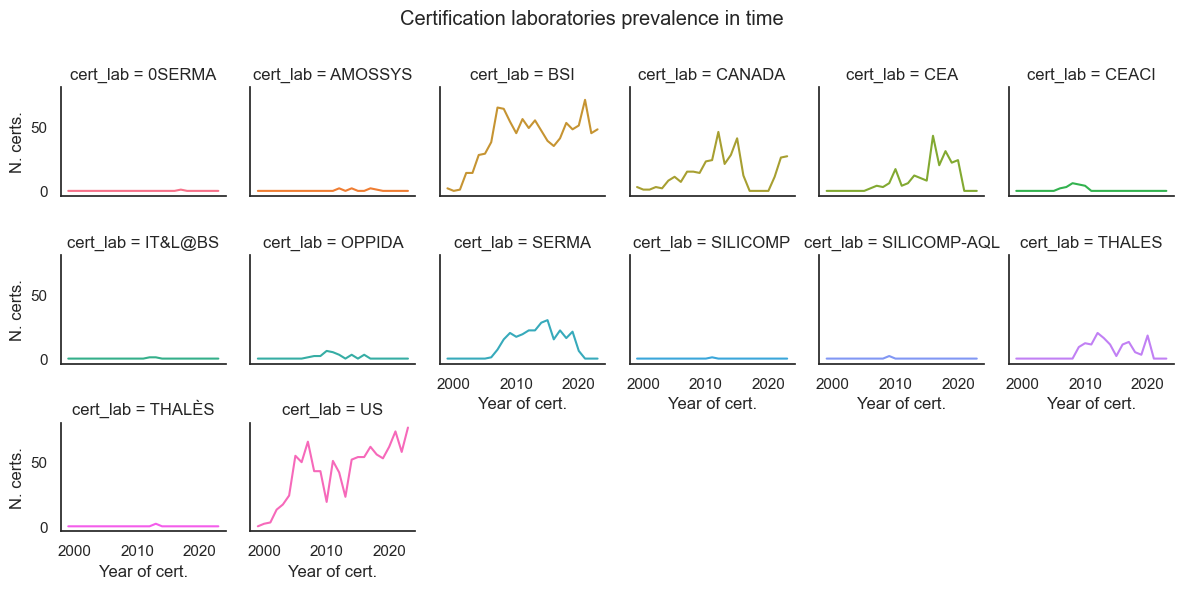

In [11]:
schemes = df.loc[(df.scheme.notnull()) & (df.year_from < 2024)].groupby(["year_from", "scheme"], as_index=False).size()
g = sns.FacetGrid(schemes, col="scheme", hue="scheme", col_wrap=6, height=2, ylim=(0, 100))
g.map(sns.lineplot, "year_from", "size")
g.set(xlabel="Year of cert.", ylabel="N. certs.")
g.fig.subplots_adjust(top=0.90)
g.fig.suptitle("National scheme prevalence in time")
plt.show()

labs = df.loc[(df.cert_lab.notnull()) & (df.year_from < 2024)].groupby(["year_from", "cert_lab"], as_index=False).size()
g = sns.FacetGrid(labs, col="cert_lab", hue="cert_lab", col_wrap=6, height=2)
g.map(sns.lineplot, "year_from", "size")
g.set(xlabel="Year of cert.", ylabel="N. certs.")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Certification laboratories prevalence in time")
plt.show()

## Prints stats and commands for LaTex

In [ ]:
total_certs = schemes["size"].sum()

n_certs_smartcards = df.loc[df.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems"].shape[0]

interesting_schemes = ["US", "DE", "FR", "JP", "CA"]

for scheme in interesting_schemes:
    frac = schemes.loc[schemes.scheme == scheme, "size"].sum()
    print(f"Number of {scheme} certs: {frac} ({(frac * 100 / total_certs):.2f}%)")

frac = schemes.loc[schemes.scheme.isin(interesting_schemes), "size"].sum()
print(f"Popular schemes constitute: {frac} ({(frac * 100 / total_certs):.2f}%)")

print(f"\nLatex commands:\n")
for scheme in interesting_schemes:
    frac = 100 * schemes.loc[schemes.scheme == scheme, "size"].sum() / total_certs
    print(f"\\newcommand{{\\fractionCerts{scheme}}}{{${frac:.0f}\%$}}")

frac = 100 * schemes.loc[schemes.scheme.isin(interesting_schemes), "size"].sum() / total_certs
print(f"\\newcommand{{\\fractionCertsPopularSchemes}}{{${frac:.0f}\%$}}")

# Print some commands related to general CC stats
print(f"\\newcommand{{\\numCCActiveCerts}}{{${df.loc[df.status == 'active'].shape[0]}$}}")
print(f"\\newcommand{{\\numCCArchivedCerts}}{{${df.loc[df.status == 'archived'].shape[0]}$}}")
print(f"\\newcommand{{\\fractioncertspopularcategories}}{{${(100 * n_certs_popular / n_certs_all):.0f}\%$}}")
print(f"\\newcommand{{\\fractionCertsSmartcards}}{{${(100 * n_certs_smartcards / n_certs_all):.0f}\%$}}")
print(f"\\newcommand{{\\numCCBulkArchivedTwentyNineteen}}{{${(df.not_valid_after.value_counts()['2019-09-01']):.0f}$}}")

# Number of attempts to convert documents pdf->txt
num_cc_convert_attempts = sum(bool(cert.state.st_pdf_path) for cert in dset) + sum(
    bool(cert.state.report_pdf_path) for cert in dset
)
# Number of OCR attempts
num_cc_ocr_attempted = sum(bool(cert.state.st_convert_garbage) for cert in dset) + sum(
    bool(cert.state.report_convert_garbage) for cert in dset
)
num_cc_ocr_success = sum(bool(cert.state.st_convert_garbage and cert.state.st_convert_ok) for cert in dset) + sum(
    bool(cert.state.report_convert_garbage and cert.state.report_convert_ok) for cert in dset
)

print(f"\\newcommand{{\\numCcConvertAttempts}}{{${num_cc_convert_attempts}$}}")
print(f"\\newcommand{{\\numCcOcrAttempted}}{{${num_cc_ocr_attempted}$}}")
print(f"\\newcommand{{\\numCcOcrSuccess}}{{${num_cc_ocr_success}$}}")

# Load number of different schemes for cert ids and regexes to match theme
with open("../../src/sec_certs/rules.yaml") as handle:
    rules_yaml = yaml.load(handle, Loader=yaml.FullLoader)

num_cc_schemes = len(rules_yaml["cc_cert_id"].keys())
num_cc_scheme_id_rules = sum(len(rules_yaml["cc_cert_id"][x]) for x in rules_yaml["cc_cert_id"])

print(f"\\newcommand{{\\numccschemes}}{{${num_cc_schemes}$}}")
print(f"\\newcommand{{\\numccschemeidrules}}{{${num_cc_scheme_id_rules}$}}")

/var/folders/1h/qt5h035n5rzcjdmfl295hrk80000gn/T/ipykernel_18601/299983924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interesting_schemes.scheme = interesting_schemes.scheme.cat.remove_unused_categories()


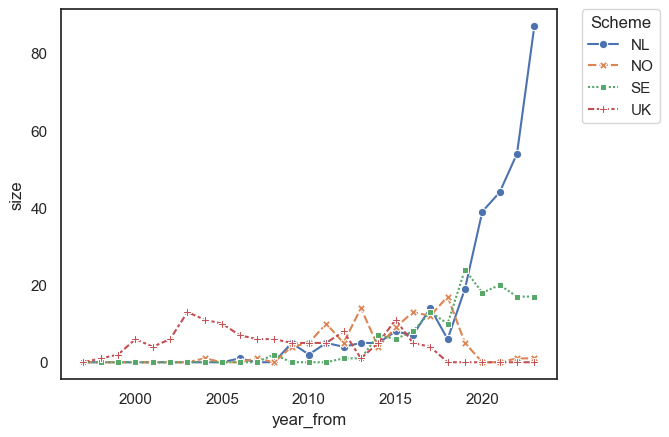

In [12]:
interesting_schemes = schemes.loc[schemes.scheme.isin({"NL", "SE", "NO", "UK"})]
interesting_schemes.scheme = interesting_schemes.scheme.cat.remove_unused_categories()
interesting_schemes.to_csv(RESULTS_DIR / "interesting_schemes.csv")

line = sns.lineplot(
    data=interesting_schemes, x="year_from", y="size", hue="scheme", style="scheme", markers=True, dashes=True
)
line.legend(title="Scheme", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

## Popularity of keywords extracted from security targets over time

In [ ]:
# TODO: Resolve duplicity in crypto_scheme mac
st_keywords_df = dset.get_keywords_df("st_keywords").drop(columns=["crypto_scheme.MAC"])
st_keywords_df = (
    st_keywords_df.rename(columns={x: x.split(".")[-1] for x in st_keywords_df.columns})
    .fillna(0)
    .applymap(lambda x: x > 0)
)

df_keywords = df.loc[:, ["category", "eal", "not_valid_before", "not_valid_after", "year_from"]].copy()
df_keywords = df_keywords.join(st_keywords_df).loc[df_keywords.year_from < 2022].copy()

figure, axes = plt.subplots(4, 3)
figure.set_size_inches(20, 20)
figure.set_tight_layout(True)
row = 0
col = 0

for examined_category in PANDAS_KEYWORDS_CATEGORIES:
    cc_rules_subset = rules_get_subset(examined_category)
    keywords = [x.split(".")[-1] for x in extract_key_paths(cc_rules_subset, examined_category)]
    top_n_keywords = df_keywords.loc[:, keywords].sum().sort_values(ascending=False).head(10).index

    # Count number of non-zero rows for each year, weight by number of certificates issued in the given year.
    crypto = df_keywords.groupby("year_from")[top_n_keywords].sum()
    crypto["n_certs"] = df_keywords.groupby("year_from").size()
    crypto.iloc[:, :-1] = crypto.iloc[:, :-1].div(crypto.n_certs, axis=0) * 100
    crypto = (
        crypto.drop(columns=["n_certs"])
        .reset_index()
        .melt(id_vars="year_from", var_name="keyword", value_name="percentage")
    )  # Bring to tidy form

    line = sns.lineplot(data=crypto, x="year_from", y="percentage", hue="keyword", ax=axes[row][col])
    line.set(
        title=f"Density of {examined_category} keywords over time",
        xlabel="Year of certification",
        ylabel="% of certs. containing keyword",
    )
    line.yaxis.set_major_formatter(mtick.PercentFormatter())
    line.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

    if col == 2:
        col = 0
        row += 1
    else:
        col += 1

In [ ]:
frac_sha2_2014 = (
    df_keywords.loc[(df_keywords.year_from == 2014) & (df_keywords.SHA2)].shape[0]
    / df_keywords.loc[df_keywords.year_from == 2014].shape[0]
)
frac_sha2_2021 = (
    df_keywords.loc[(df_keywords.year_from == 2021) & (df_keywords.SHA2)].shape[0]
    / df_keywords.loc[df_keywords.year_from == 2021].shape[0]
)
frac_sha1_2021 = (
    df_keywords.loc[(df_keywords.year_from == 2021) & (df_keywords.SHA1)].shape[0]
    / df_keywords.loc[df_keywords.year_from == 2021].shape[0]
)

pq_keywords = [x.split(".")[-1] for x in extract_key_paths(rules_get_subset("pq_crypto"), "pq_crypto")]
n_positive_pq_certs = df_keywords[pq_keywords].any(axis=1).sum()

ec_keywords = [x.split(".")[-1] for x in extract_key_paths(rules_get_subset("ecc_curve"), "ecc_curve")]
frac_nist_2021 = (
    df_keywords.loc[(df_keywords.year_from == 2021) & (df_keywords.NIST)].shape[0]
    / df_keywords.loc[(df_keywords.year_from == 2021)].shape[0]
)
frac_brainpool_2021 = (
    df_keywords.loc[(df_keywords.year_from == 2021) & (df_keywords.Brainpool)].shape[0]
    / df_keywords.loc[(df_keywords.year_from == 2021)].shape[0]
)


print(f"\\newcommand{{\\numShaTwoFourteen}}{{${(100 * frac_sha2_2014):.0f}\%$}}")
print(f"\\newcommand{{\\numShaTwoTwentyOne}}{{${(100 * frac_sha2_2021):.0f}\%$}}")
print(f"\\newcommand{{\\numShaOneTwentyOne}}{{${(100 * frac_sha1_2021):.0f}\%$}}")

print(f"\\newcommand{{\\numSearchedPQKeywords}}{{${len(pq_keywords)}$}}")
print(f"\\newcommand{{\\numCertsWithPQKeywords}}{{${n_positive_pq_certs}$}}")

print(f"\\newcommand{{\\numSearchedECKeywords}}{{${len(ec_keywords)}$}}")
print(f"\\newcommand{{\\numECNISTTwentyOne}}{{${(100 * frac_nist_2021):.0f}\%$}}")
print(f"\\newcommand{{\\numECBrainpoolTwentyOne}}{{${(100 * frac_brainpool_2021):.0f}\%$}}")